# Baseline Model and Training
## Setup and loading data

In [15]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [16]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

Note: After the following pip install, need to restart the kernel.

In [17]:
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

from collections import defaultdict
from collections import Counter

import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random

In [19]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV

import scikitplot as skplt

In [20]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [21]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42

In [22]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [23]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

### Load data

In [24]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [25]:
# Load data
if IN_COLAB:
    file = open('drive/My Drive/Colab Data/nontext_train_small.pickle', 'rb')
else:
    file = open('../data/train_data/nontext_train_small.pickle', 'rb')

train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df.head()

(403, 10)


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.73883,-0.166667,-0.017862,-15.485275,0.00022
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.73883,-0.200000,-0.017862,-9.537496,0.00022
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.73883,-0.333333,-0.017862,-3.116275,0.00022
1983-01-14,0,0,-0.382295,42.8,-68.0,1.73883,-0.233333,-0.017862,-0.774432,0.00022
1983-01-21,0,0,-0.382295,42.8,-68.0,1.73883,-0.233333,-0.043808,-0.774432,0.00022


### Balancing the classes

In [26]:
# Percentage before the balancing
n_hold = sum(1 for each in train_df['target'] if each == 0)
n_lower = sum(1 for each in train_df['target'] if each == -1)
n_raise = sum(1 for each in train_df['target'] if each == 1)
N_examples = len(train_df)

print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


Here, take random sampling approach to balance the data. Though it loses some data, easy to process and less prone to the bias.<BER />

_Update: Decided not to do this as we do not have a lot of data. Consider different approach to tackle this imbalanced data issue. Thus, set keep_prob = 1 (keep everything). _

In [27]:
# Too many Hold. Better to randomly pick to even the distribution
n_hold = sum(1 for each in train_df['target'] if each == 0)
N_examples = len(train_df)

# Keep probability (specify decimal value between 0 and 1)
# keep_prob = (N_examples - n_hold)/2/n_hold
keep_prob = 1

balanced = pd.concat([train_df.loc[train_df['target'] != 0], train_df.loc[train_df['target'] == 0].sample(frac=keep_prob, random_state=1)])
balanced.sort_index(ascending=True, inplace=True)

n_hold = sum(1 for each in balanced['target'] if each == 0)
n_lower = sum(1 for each in balanced['target'] if each == -1)
n_raise = sum(1 for each in balanced['target'] if each == 1)
N_examples = len(balanced['target'])
print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


In [28]:
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

In [29]:
Y_balanced = balanced['target'].map(convert_class)
X_balanced = balanced.drop(columns=['target'])


In [84]:
# Because the prediction should be on the latest and should not look back, use shuffle=False
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_balanced.values, Y_balanced.values, test_size=0.2, shuffle=False)

In [31]:
print("Training Data: Total {}, {}".format(len(Y_train), Counter(Y_train)))
print("Test Data: Total {}, {}".format(len(Y_test), Counter(Y_test)))

Training Data: Total 322, Counter({2: 206, 1: 64, 3: 52})
Test Data: Total 81, Counter({2: 60, 3: 13, 1: 8})


In [32]:
Y_balanced.head()

date
1982-10-05    1
1982-11-16    1
1982-12-21    2
1983-01-14    2
1983-01-21    2
Name: target, dtype: int64

# Modeling and Training

## Briefly check how different classifiers perform

In [66]:
# Use Stratified KFold Cross Validation
n_fold = 7
kfold = StratifiedKFold(n_splits=n_fold)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

In [34]:
# Roughly check base classifiers without hyperparameter setting

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))


cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std})

In [35]:
cv_res.sort_values(by='CVAccMeans', ascending=False)

,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
0,SVC,0.639752,0.010758,0.260084,0.002662
4,ExtraTrees,0.618012,0.090649,0.484201,0.120370
3,RandomForest,0.611801,0.076577,0.476292,0.103977
9,LinearDiscriminantAnalysis,0.611801,0.080865,0.463676,0.105840
6,MultipleLayerPerceptron,0.599379,0.034582,0.367926,0.119781
8,LogisticRegression,0.593168,0.069443,0.354574,0.057658
5,GradientBoosting,0.577640,0.118989,0.450105,0.153545
11,Perceptron,0.537267,0.118339,0.281992,0.053860
7,KNeighboors,0.524845,0.058596,0.384893,0.073336
10,GaussianNB,0.521739,0.204922,0.475502,0.194703


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

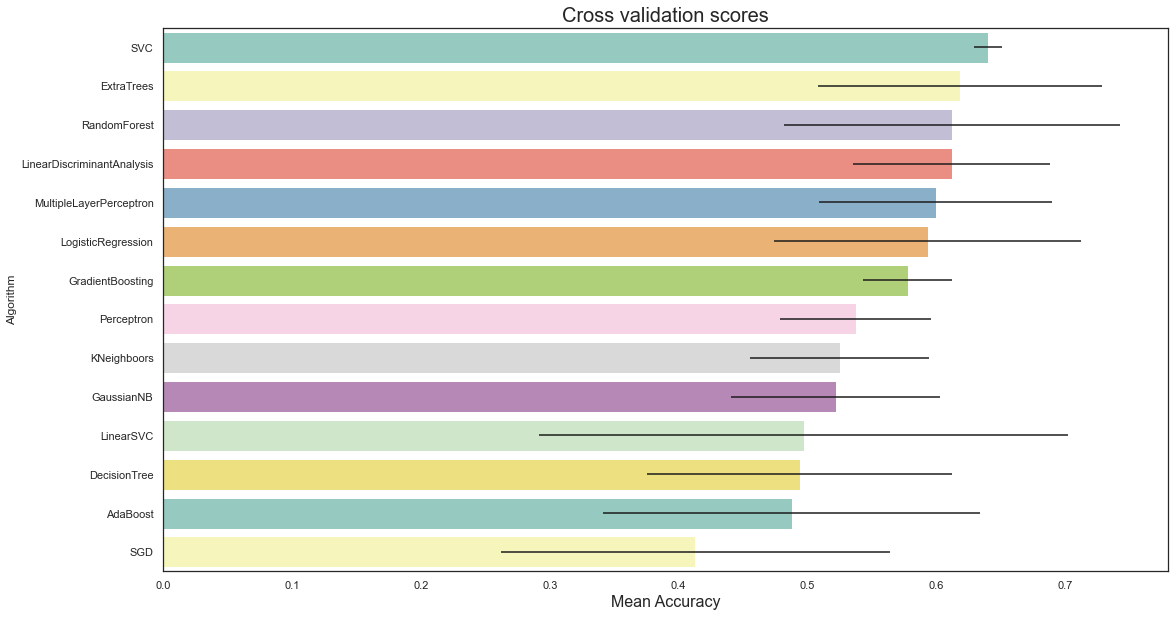

In [36]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation scores", size=20)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

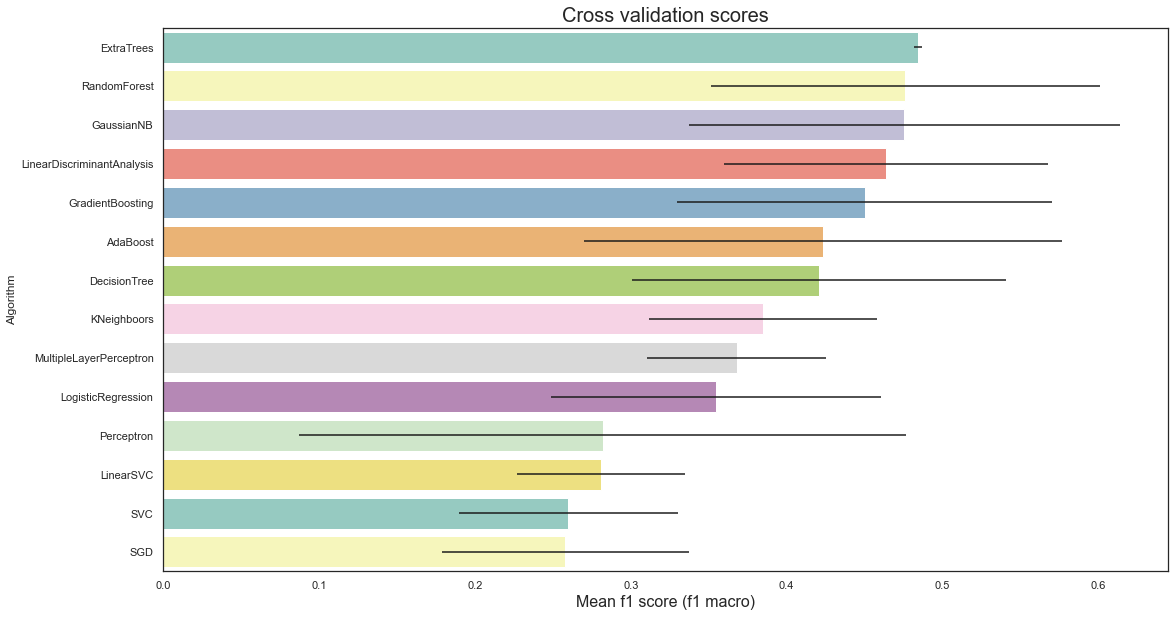

In [37]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation scores", size=20)

## Hyperparameter Tuning
Grid search to find an optimal hyperparameter. First define functions to perform training and show results.

In [38]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [39]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


### ADA Boost (on Decision Tree)

In [40]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

In [41]:
# Perform Random Hyperparamter Grid Search
rand_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" : [10, 50, 100, 200, 500],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]}

rand_model = RandomizedSearchCV(estimator=ada_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)


Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s


0.4458190557393852
{'n_estimators': 50, 'learning_rate': 0.01, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'entropy', 'algorithm': 'SAMME.R'}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.7s finished
[2020-11-10 16:38:16,613][INFO] ## Training - acc: 1.00000000, f1: 1.00000000
[2020-11-10 16:38:16,613][INFO] ## Training - acc: 1.00000000, f1: 1.00000000
[2020-11-10 16:38:16,617][INFO] ## Test - acc: 0.53086420, f1: 0.33485040
[2020-11-10 16:38:16,617][INFO] ## Test - acc: 0.53086420, f1: 0.33485040


Best Score:  0.420283849162601
Best Param:  {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 1}


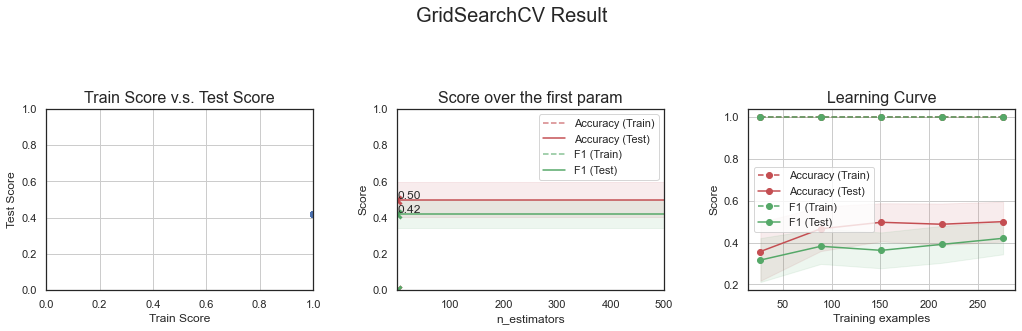

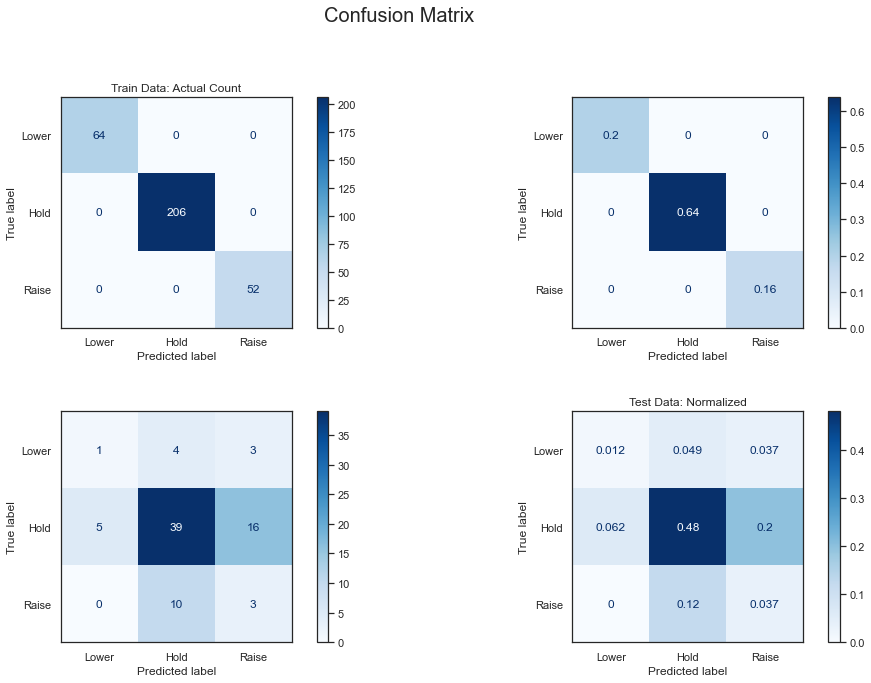

In [42]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME.R'],
              'learning_rate': [0.01]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

### Extra Tree

In [43]:
#ExtraTrees 
ext_clf = ExtraTreesClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 10, 20],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "bootstrap": [False],
              "n_estimators" : [1, 2, 5, 10, 20, 100, 200, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=ext_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1368 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2085 out of 2100 | elapsed:  1.8min remaining:    0.8s


0.4916508602216148
{'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  1.8min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    6.5s finished
[2020-11-10 16:40:12,745][INFO] ## Training - acc: 0.72981366, f1: 0.61955455
[2020-11-10 16:40:12,745][INFO] ## Training - acc: 0.72981366, f1: 0.61955455
[2020-11-10 16:40:12,749][INFO] ## Test - acc: 0.62962963, f1: 0.25757576
[2020-11-10 16:40:12,749][INFO] ## Test - acc: 0.62962963, f1: 0.25757576


Best Score:  0.45972774094076013
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 29}


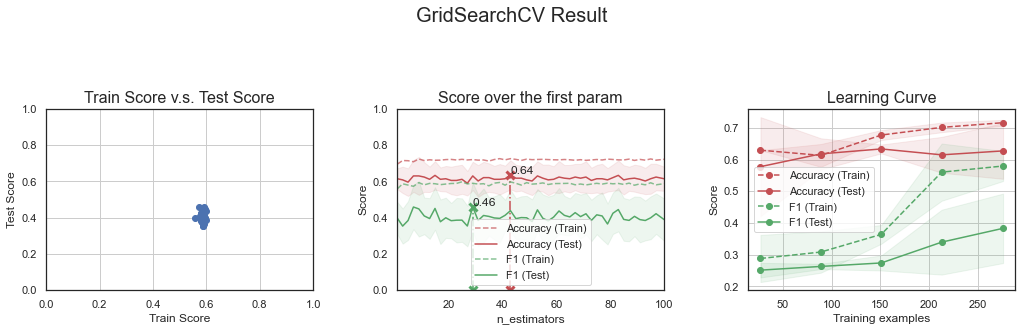

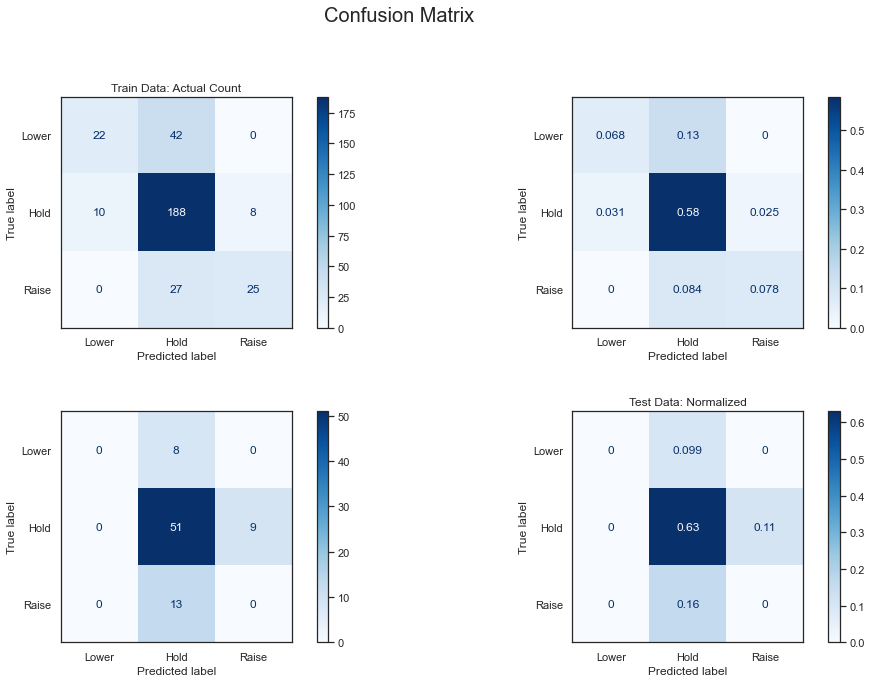

In [44]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 100, 50, dtype=int),
              'min_samples_split': [5],
              'min_samples_leaf': [10],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

### Random Forest

In [45]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 10],
              "min_samples_leaf": [1, 3, 5, 7, 10, 15],
              "bootstrap": [False],
              "n_estimators" :[1, 2, 5, 10, 100, 200, 300, 500, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=rf_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1634 tasks      | elapsed:  2.1min


0.5484916564835116
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 5, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  2.7min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   42.1s finished
[2020-11-10 16:43:39,535][INFO] ## Training - acc: 0.89440994, f1: 0.86478160
[2020-11-10 16:43:39,535][INFO] ## Training - acc: 0.89440994, f1: 0.86478160
[2020-11-10 16:43:39,539][INFO] ## Test - acc: 0.65432099, f1: 0.40138889
[2020-11-10 16:43:39,539][INFO] ## Test - acc: 0.65432099, f1: 0.40138889


Best Score:  0.4909626364665362
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1}


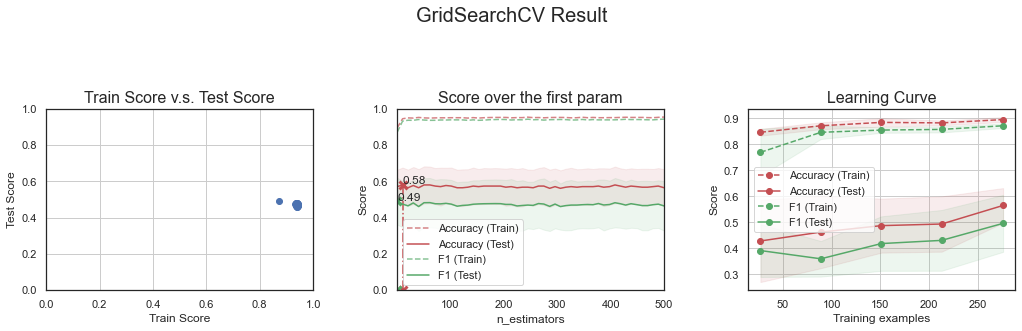

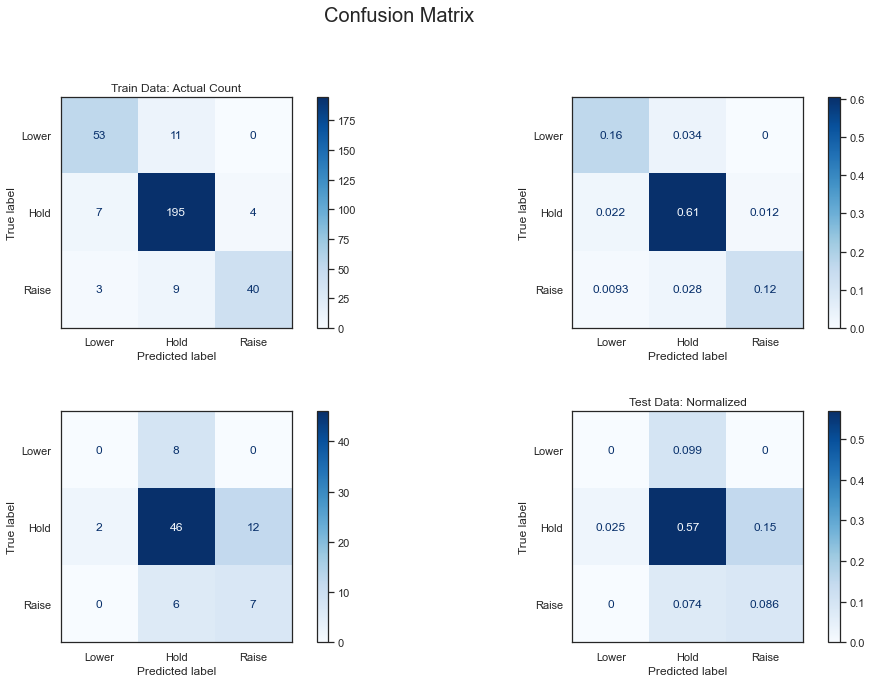

In [46]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [2],
              'min_samples_leaf': [3],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

### Gradient Boosting

In [47]:
# Gradient boosting
gb_clf = GradientBoostingClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [1, 10, 100, 200, 300, 1000],
              'learning_rate': [0.1, 0.05, 0.01, 0.005],
              'max_depth': [2, 4, 6, 8, 10],
              'min_samples_leaf': [2, 5, 10, 15, 20, 30, 50, 100, 200, 300],
              'max_features': [0.8, 0.6, 0.4, 0.2, 0.1]
              }

rand_model = RandomizedSearchCV(estimator=gb_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)


Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  6.6min finished


0.5243053084944617
{'n_estimators': 100, 'min_samples_leaf': 30, 'max_features': 0.4, 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.05}


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   41.9s finished
[2020-11-10 16:50:57,964][INFO] ## Training - acc: 0.86645963, f1: 0.83349662
[2020-11-10 16:50:57,964][INFO] ## Training - acc: 0.86645963, f1: 0.83349662
[2020-11-10 16:50:57,968][INFO] ## Test - acc: 0.67901235, f1: 0.37229167
[2020-11-10 16:50:57,968][INFO] ## Test - acc: 0.67901235, f1: 0.37229167


Best Score:  0.5221854226630159
Best Param:  {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 2, 'max_features': 0.6, 'min_samples_leaf': 15, 'n_estimators': 194}


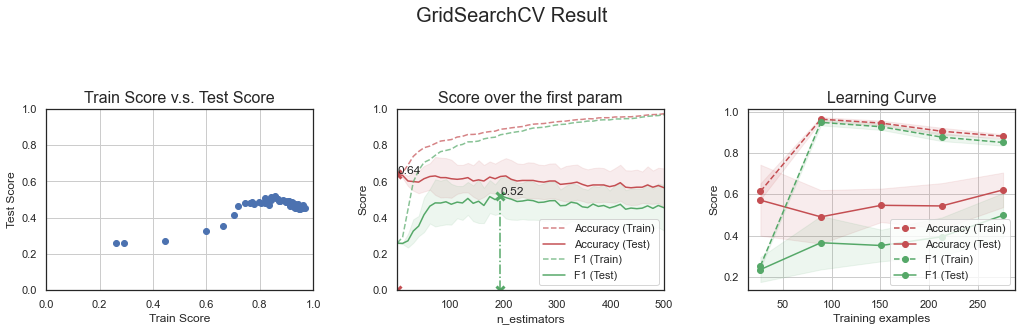

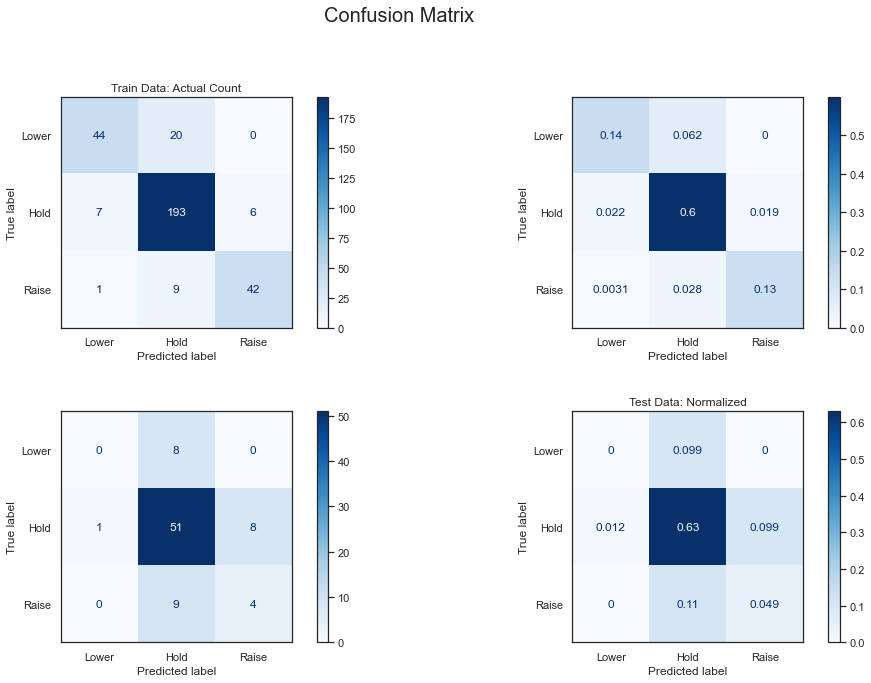

In [48]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_leaf': [15],
              'max_features': [0.6],
              'max_depth': [2],
              'loss': ['deviance'],
              'learning_rate': [0.05]}

gb_model = train_grid_search(gb_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
gb_best = gb_model.best_estimator_

### SVM

In [49]:
# Support Vector Machine
svm_clf = SVC(probability=True)

# Perform Random Hyperparamter Grid Search
rand_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                  'C': [1, 2, 3, 5, 8, 10, 50, 100, 200, 300, 500, 1000]}

rand_model = RandomizedSearchCV(estimator=svm_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 84 is smaller than n_iter=300. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 7 folds for each of 84 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


0.4491862636481613
{'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    2.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    2.3s finished
[2020-11-10 16:51:10,014][INFO] ## Training - acc: 0.88509317, f1: 0.85582326
[2020-11-10 16:51:10,014][INFO] ## Training - acc: 0.88509317, f1: 0.85582326
[2020-11-10 16:51:10,019][INFO] ## Test - acc: 0.59259259, f1: 0.36112532
[2020-11-10 16:51:10,019][INFO] ## Test - acc: 0.59259259, f1: 0.36112532


Best Score:  0.4329985122610921
Best Param:  {'C': 10, 'gamma': 0.004177551020408164, 'kernel': 'rbf'}


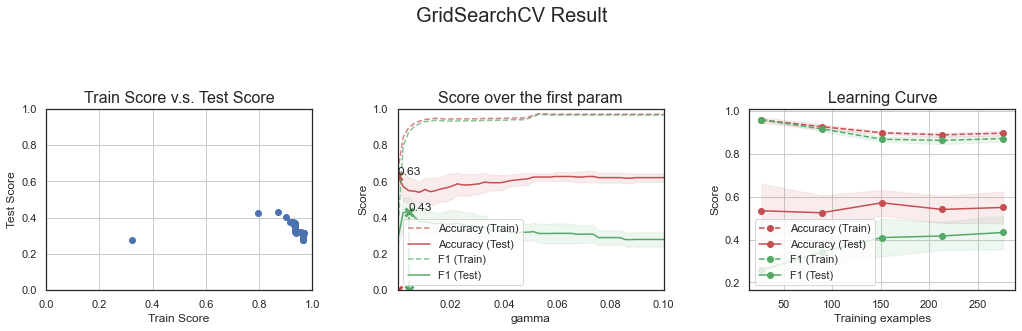

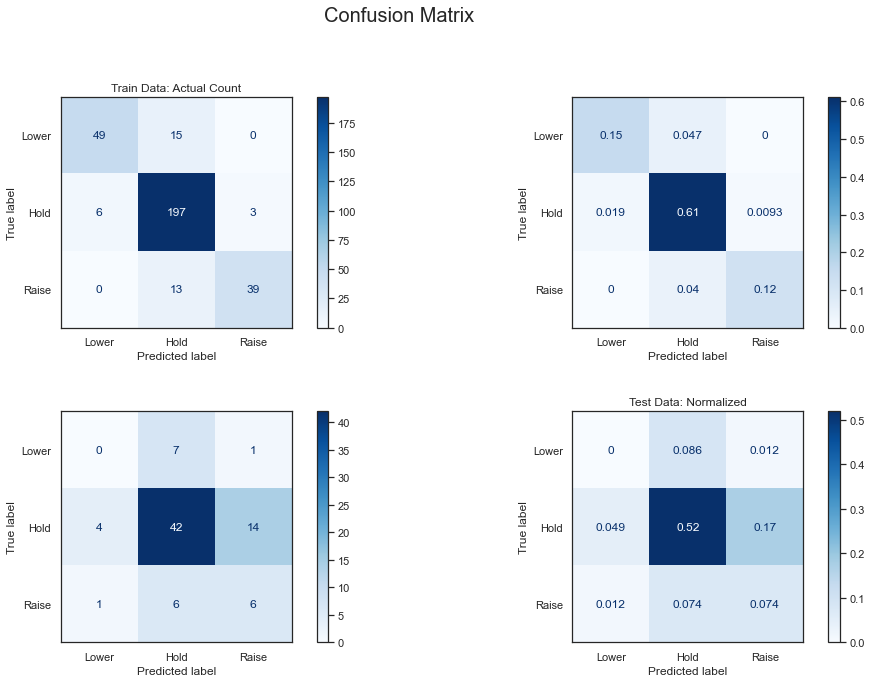

In [50]:
# Perform Grid Search
param_grid = {'gamma': np.linspace(0.0001, 0.1, 50, dtype=float),
              'C': [10],
              'kernel': ['rbf']}

svm_model = train_grid_search(svm_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
svm_best = svm_model.best_estimator_

### Feature Importance
Check feature importance on four tree-based classifiers out of ten.

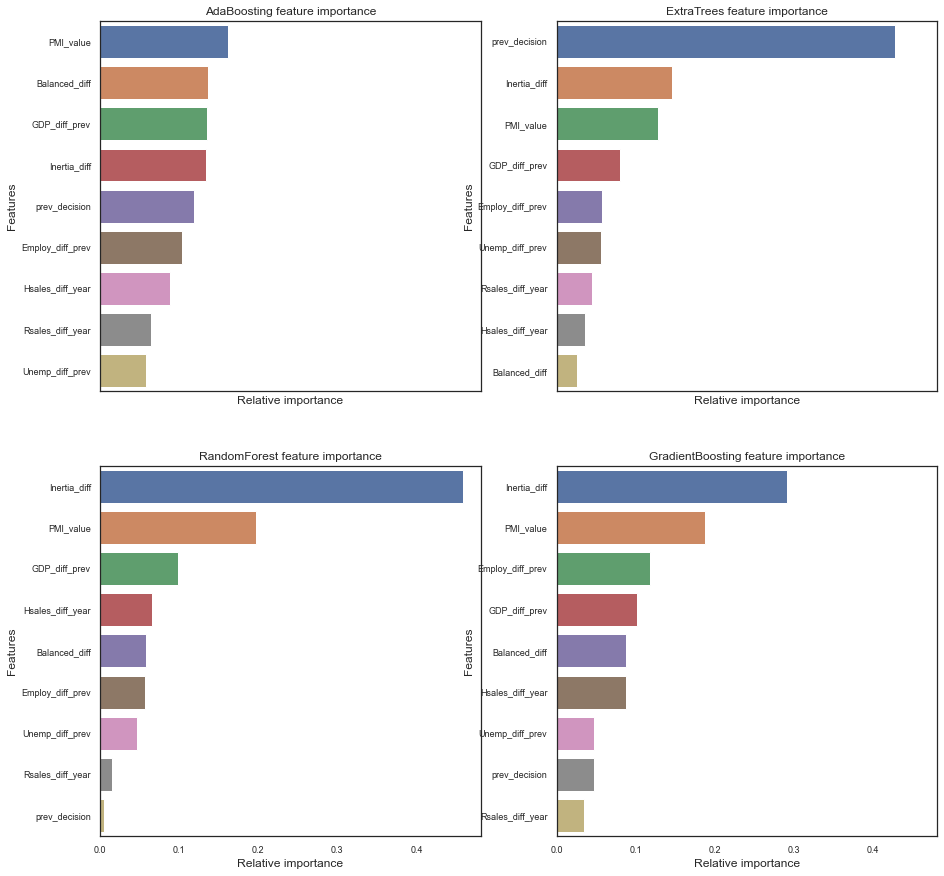

In [51]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_balanced.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

## Ensembling

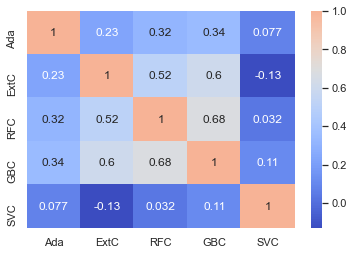

In [52]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")
test_svm = pd.Series(svm_best.predict(X_test), name="SVC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb, test_svm],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


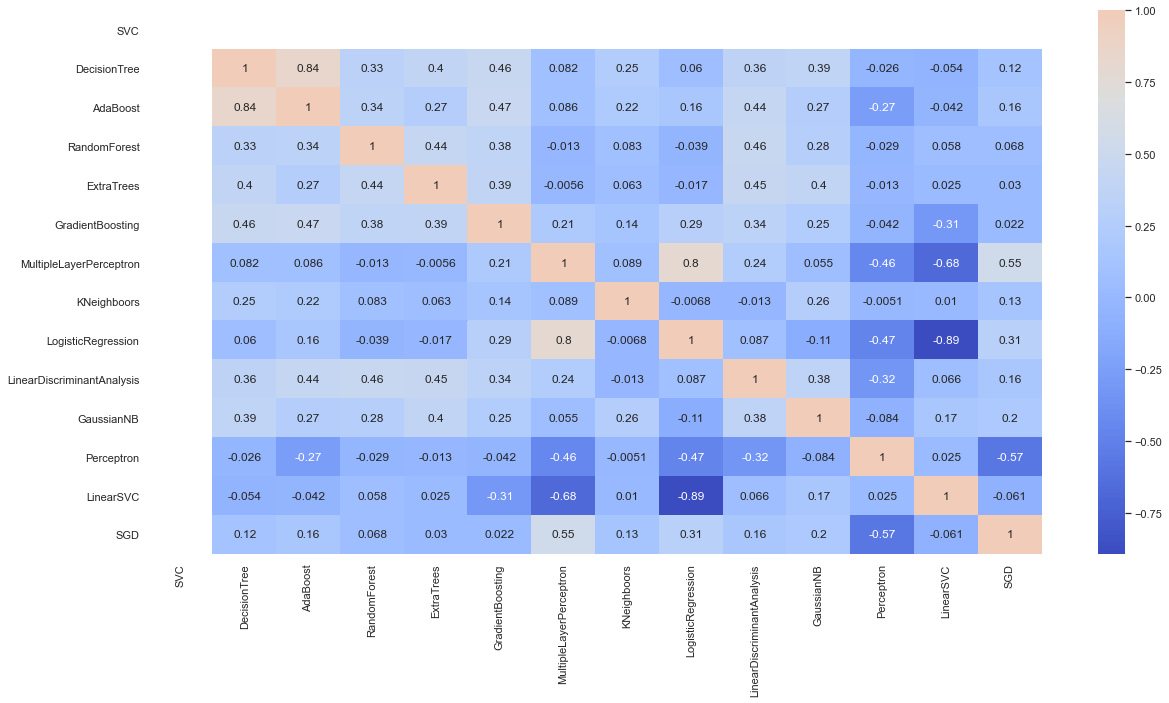

In [53]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

### Voting Classifier

In [54]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best), 
                                           ('svmc', svm_best)], voting='soft', n_jobs=-1)

# # Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best.fit(X_train, Y_train)

VotingClassifier(estimators=[('adac',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(splitter='random'),
                                                 learning_rate=0.01,
                                                 n_estimators=1,
                                                 random_state=42)),
                             ('extc',
                              ExtraTreesClassifier(max_features=8,
                                                   min_samples_leaf=10,
                                                   min_samples_split=5,
                                                   n_estimators=29)),
                             ('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=8,
                                                     min_samples_leaf=3,
                                                     n_estimators=1)),
              

In [55]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-11-10 16:51:15,479][INFO] ## Training - acc: 0.96583851, f1: 0.95810330
[2020-11-10 16:51:15,479][INFO] ## Training - acc: 0.96583851, f1: 0.95810330
[2020-11-10 16:51:15,481][INFO] ## Test - acc: 0.69135802, f1: 0.42024900
[2020-11-10 16:51:15,481][INFO] ## Test - acc: 0.69135802, f1: 0.42024900


### Stacking by XGBoost

In [85]:
# Class to get out-of-fold predictions
def get_oof(clf, x_train, y_train, x_test):
    #Set parameters for ensembling
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    oof_train = np.zeros((n_train,))
    oof_test = np.zeros((n_test,))
    oof_test_skf = np.empty((n_fold, n_test))
    
    for i, (train_index, test_index) in enumerate(kfold.split(y_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1, 1)

In [86]:
# Create OOF train and test predictions.
ada_oof_train, ada_oof_test = get_oof(ada_best, X_train, Y_train, X_test) # AdaBoost 
ext_oof_train, ext_oof_test = get_oof(ext_best, X_train, Y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf_best, X_train, Y_train, X_test) # Random Forest
gb_oof_train, gb_oof_test = get_oof(gb_best, X_train, Y_train, X_test) # Gradient Boost
svmc_oof_train, svmc_oof_test = get_oof(svm_best, X_train, Y_train, X_test) # Support Vector Classifier

In [87]:
X_train_xgb = np.concatenate((ada_oof_train, ext_oof_train, rf_oof_train, gb_oof_train, svmc_oof_train), axis=1)
X_test_xgb = np.concatenate((ada_oof_test, ext_oof_test, rf_oof_test, gb_oof_test, svmc_oof_test), axis=1)

In [92]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    n_estimator=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(X_train_xgb, Y_train)

# Predict
gbm_pred_train = gbm.predict(X_train_xgb)
gbm_pred_test = gbm.predict(X_test_xgb)

xgb_acc_train, xgb_f1_train = metric(Y_train, gbm_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (xgb_acc_train, xgb_f1_train))

xgb_acc_test, xgb_f1_test = metric(Y_test, gbm_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (xgb_acc_test, xgb_f1_test))

[2020-11-10 17:29:46,276][INFO] ## Train - acc: 0.68944099, f1: 0.50584673
[2020-11-10 17:29:46,276][INFO] ## Train - acc: 0.68944099, f1: 0.50584673
[2020-11-10 17:29:46,280][INFO] ## Test - acc: 0.75308642, f1: 0.36835749
[2020-11-10 17:29:46,280][INFO] ## Test - acc: 0.75308642, f1: 0.36835749


[17:29:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




# Result

In [93]:
result_clf = [('AdaDTC', ada_best),
              ('ExtraTree', ext_best), 
              ('RandomForest', rf_best),
              ('GradientBoost', gb_best), 
              ('SVM', svm_best),
              ('Voting', voting_best)]
results = []

for clf in result_clf:
    pred_train = clf[1].predict(pd.DataFrame(X_train))
    pred_test = clf[1].predict(pd.DataFrame(X_test))
    train_acc, train_f1 = metric(Y_train, pred_train)
    test_acc, test_f1 = metric(Y_test, pred_test)
    results.append((clf[0], train_acc, train_f1, test_acc, test_f1))

results.append(('XGBoost', xgb_acc_train, xgb_f1_train, xgb_acc_test, xgb_f1_test))
result_df = pd.DataFrame(results, columns=['Classifier', 'Train Accuracy', 'Train F1', 'Test Accuracy', 'Test F1'])
result_df


,Classifier,Train Accuracy,Train F1,Test Accuracy,Test F1
0,AdaDTC,0.928571,0.916317,0.555556,0.306723
1,ExtraTree,0.711180,0.535017,0.703704,0.275362
2,RandomForest,0.844720,0.812506,0.728395,0.461609
3,GradientBoost,0.847826,0.800463,0.691358,0.379845
4,SVM,0.854037,0.814874,0.604938,0.378947
5,Voting,0.965839,0.958103,0.691358,0.420249
6,XGBoost,0.689441,0.505847,0.753086,0.368357


As Test F1 score is the highest, take Random Forest as the baseline model.

In [94]:
baseline_model = rf_best
pred_test = baseline_model.predict(pd.DataFrame(X_test))
prediction_df = pd.concat([pd.Series(balanced.index.values), pd.Series(pred_test, name="Predict")],axis=1)

## Save the result

In [95]:
def save_data(df, file_name, dir_name='../data/result/', index_csv=True):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=index_csv)

In [96]:
# Save result
if IN_COLAB:
    dir_name = 'drive/My Drive/Colab Data/'
else:
    dir_name = '../data/result/'

save_data(result_df, "result_scores", dir_name, index_csv=False)
save_data(prediction_df, "baseline_predictions", dir_name, index_csv=False)
save_data(X_balanced, "training_data", dir_name, index_csv=True)